In [1]:
import aomip
import numpy as np
import json
from os.path import join
from tifffile import imsave, imread
import matplotlib.pyplot as plt
import GradientDescent
from challenge import utils
import plotContour as pct
from scipy.fft import fftshift, ifftshift, fft,fft2,ifft2
from scipy.ndimage import gaussian_filter
from scipy import signal
from scipy.optimize import line_search
from utils import save_array_as_image, plot_convergence, filter_sinogram

pyelsa not build with CUDA projector support


## Homework 1: Even more gradient based methods

### Section 1: Simple 2d experiment on contour plot

In [4]:
C = np.array([[2, 1], [1, 1]])
d = np.array([1, 1])
solved = np.linalg.solve(C, d)
print('solved numpy:',solved)


solved numpy: [0. 1.]


#### Backtracking

solved backtracking: [-3.55536440e-05  1.00005753e+00]
iteration backtracking: 749


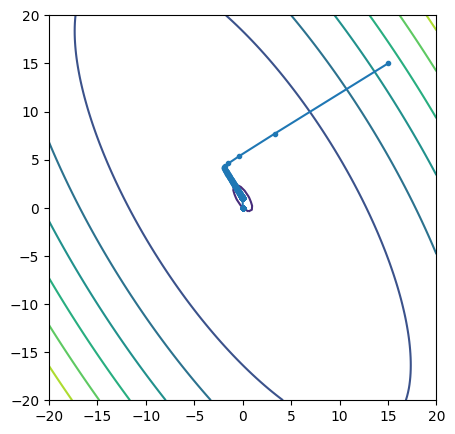

In [5]:
C = np.array([[2, 1], [1, 1]])
d = np.array([1, 1])
x_0=np.array([15, 15])

xmin, itr, history = GradientDescent.backtracking_linesearch(C,d,x_0,1e-1,0.1,0.1,eps=1e-6,iteration=6000)
print('solved backtracking:',xmin)
print('iteration backtracking:',itr)

plt.figure(figsize=(5,5))
axes = plt.gca()
pct.plotFunctionContour(pct.myFunction, [-20, 20], 100, axes)
axes.plot(history[0,:], history[1,:], marker='.')
plt.show()

#### Barzilai and Borwein

solved bb1: [-2.53665895e-07  9.99999843e-01]
iteration bb1: 6
solved bb2: [1.58878942e-16 1.00000000e+00]
iteration bb2: 8


/Users/boeykaizhe/Documents/TUM/SS 2023/Applied Optimization for Inverse Problem Praktikum/aomip-boey-kai-zhe/homework/hw04/GradientDescent.py:292: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = s.T.dot(s) / s.T.dot(y)


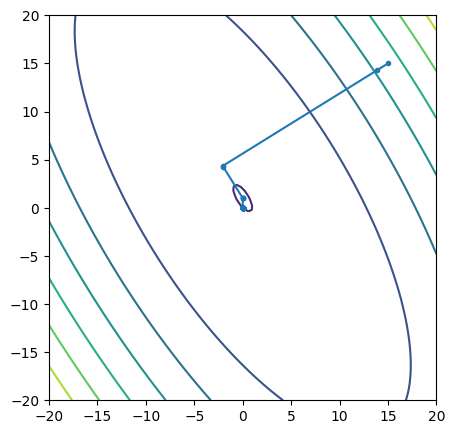

In [4]:
xmin, itr, history = GradientDescent.bb_linesearch(C,d,x_0,1e-2,bb=1)
print('solved bb1:',xmin)
print('iteration bb1:',itr)
xmin, itr, history = GradientDescent.bb_linesearch(C,d,x_0,1e-2,bb=2)
print('solved bb2:',xmin)
print('iteration bb2:',itr)

plt.figure(figsize=(5,5))
axes = plt.gca()
pct.plotFunctionContour(pct.myFunction, [-20, 20], 100, axes)
axes.plot(history[0,:], history[1,:], marker='.')
plt.show()

#### ISTA

With backtracking

solved ista: [9.75378013e-04 9.98039839e-01]
iteration ista: 458


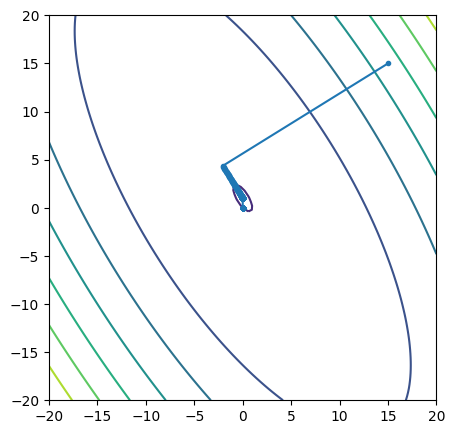

In [6]:
xmin, itr, history = GradientDescent.ista(C,d,x_0,beta=0.001,iteration=1000,backtrack=False)
print('solved ista:',xmin)
print('iteration ista:',itr)
plt.figure(figsize=(5,5))
axes = plt.gca()
pct.plotFunctionContour(pct.myFunction, [-20, 20], 100, axes)
axes.plot(history[0,:], history[1,:], marker='.')
plt.show()

Without backtracking

solved ista: [9.75378013e-04 9.98039839e-01]
iteration ista: 458


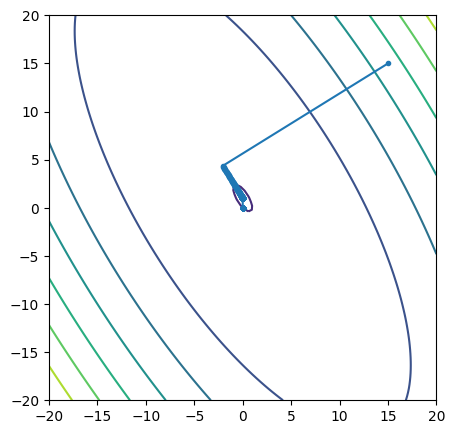

In [7]:
xmin, itr, history = GradientDescent.ista(C,d,x_0,beta=0.001,iteration=1000,backtrack=True)
print('solved ista:',xmin)
print('iteration ista:',itr)
plt.figure(figsize=(5,5))
axes = plt.gca()
pct.plotFunctionContour(pct.myFunction, [-20, 20], 100, axes)
axes.plot(history[0,:], history[1,:], marker='.')
plt.show()

#### Projected Gradient Method

solved pgd: [-3.55967897e-05  1.00005760e+00]
iteration pgd: 689


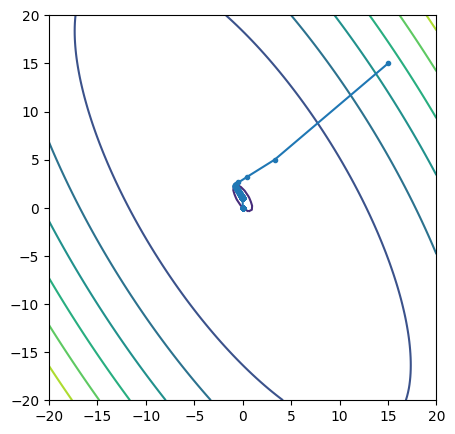

In [6]:
lb = np.array([-1,-1]) # lower bound
ub = np.array([5,5])   # upper bound
xmin, itr, history = GradientDescent.projected_gradient_descent(C,d,x_0,0.1,lb, ub, iteration=2000)
print('solved pgd:',xmin)
print('iteration pgd:',itr)
plt.figure(figsize=(5,5))
axes = plt.gca()
pct.plotFunctionContour(pct.myFunction, [-20, 20], 100, axes)
axes.plot(history[0,:], history[1,:], marker='.')
plt.show()

#### OGM1

step size OGM:  1e-01
final x:  [4.84022439e-04 1.00029914e+00]
solved OGM1: [4.84022439e-04 1.00029914e+00]
iteration OGM1: 50000


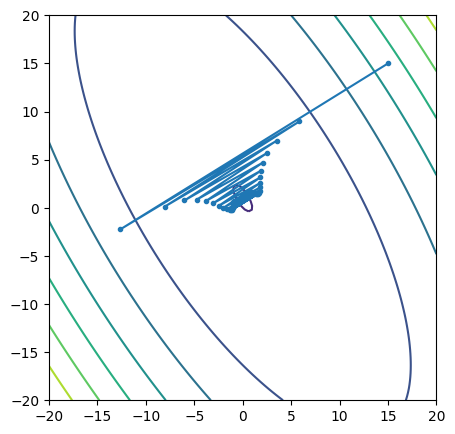

In [45]:
xmin, itr, history = GradientDescent.compute_OGM1(C,d,x_0,iteration=50000)
print('solved OGM1:',xmin)
print('iteration OGM1:',itr)
plt.figure(figsize=(5,5))
axes = plt.gca()
pct.plotFunctionContour(pct.myFunction, [-20, 20], 100, axes)
axes.plot(history[0,:], history[1,:], marker='.')
plt.show()

#### Conjugate Gradient

solved Conjugate Gradient: [-1.79278122e-15  1.00000000e+00]
iteration Conjugate Gradient: 3


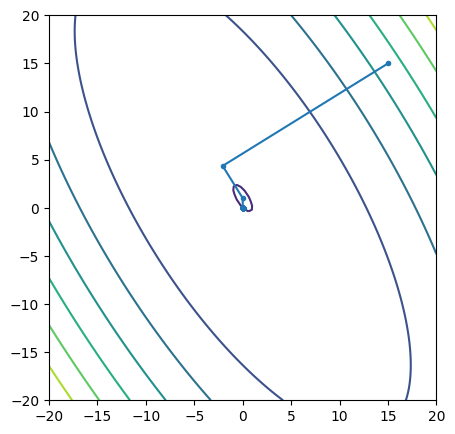

In [11]:
xmin, itr, history = GradientDescent.conjugate_gradient_normal(C,d,x_0)
print('solved Conjugate Gradient:',xmin)
print('iteration Conjugate Gradient:',itr)
plt.figure(figsize=(5,5))
axes = plt.gca()
pct.plotFunctionContour(pct.myFunction, [-20, 20], 100, axes)
axes.plot(history[0,:], history[1,:], marker='.')
plt.show()

### Section 2: simple phantom experiment

Due to longer computation time, most experiments are performed on the server and results documented in the readme, see script04

[2023-06-09 14:13:38.541] [phantom::modifiedSheppLogan] [info] creating modified Shepp Logan phantom of size 512^2
[2023-06-09 14:13:38.628] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 512 poses in an 360 degree arc


Text(0.5, 1.0, 'filtered backprojection')

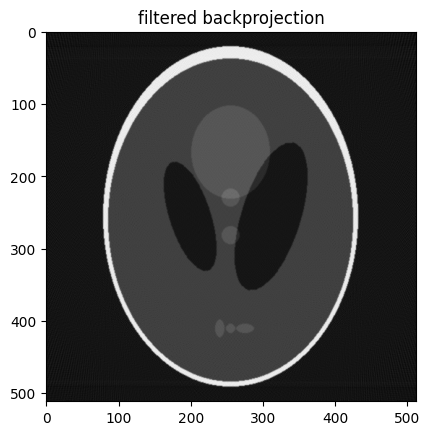

In [38]:
size = np.array([512, 512])
phantom = aomip.shepp_logan(size)
num_angles = 512
arc = 360

A = aomip.XrayOperator(size, [750], np.linspace(0, arc, num_angles), size[0]*100, size[0]*2)
sinogram = A.apply(phantom)

###################### Filter ##############################################
H = np.linspace(-1, 1, sinogram.shape[0])

ram_lak = np.abs(H)
shepp_logan = np.abs(H) * np.sinc(H / 2)
cosine = np.abs(H) * np.cos(H * np.pi / 2)

h = np.tile(shepp_logan, (512, 1)).T
fftsino = np.fft.fft(sinogram, axis=0)
projection = np.fft.fftshift(fftsino, axes=1) * np.fft.fftshift(h, axes=0)
fsino = np.real(np.fft.ifft(np.fft.ifftshift(projection, axes=1), axis=0))
###################### Filter ##############################################
img_vector = 512*512
x0 = np.random.rand(img_vector)
b = fsino.flatten()

filtered_backprojection = A.applyAdjoint(fsino)
plt.imshow(filtered_backprojection, cmap='gray')
plt.title('filtered backprojection')

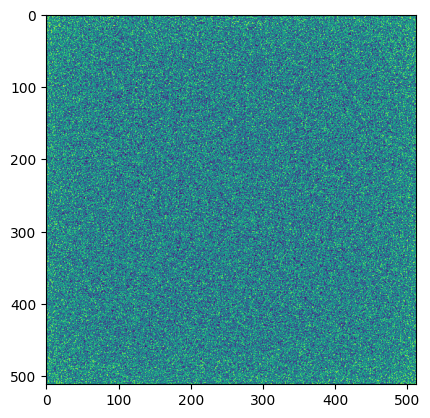

In [7]:
xmin, itr, history = GradientDescent.backtracking_linesearch(A,b,x0,1e-3,0.5,0.5,eps=1e-6,iteration=10)
xmin_reshape = xmin.reshape([512,512])
plt.imshow(xmin_reshape)

Experiment from server

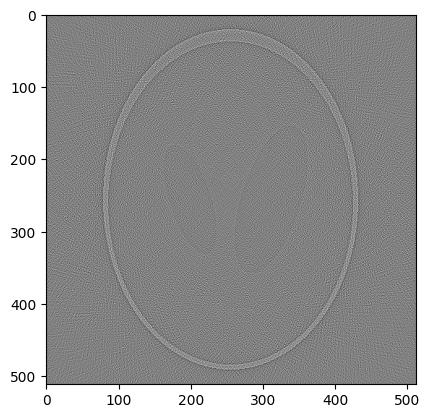

In [57]:
fpath = '/Users/boeykaizhe/Documents/TUM/ftp/hw04/img/pgd.tif'
img = imread(fpath)
plt.imshow(img, cmap='gray')

#### Section 3: Iterative Shrinkage-Thresholding Algorithm (Deblurring experiment)

Image deblurring experiment, lena is again used to perform this experiment

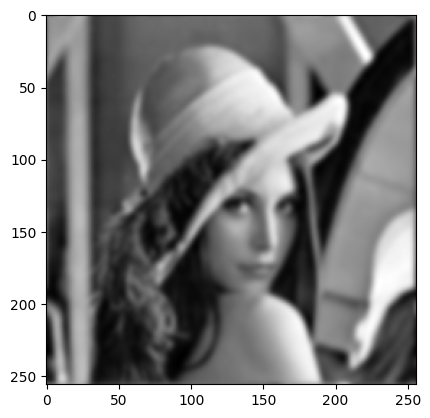

In [8]:
file_name = 'lena.tif'
image = imread(file_name)
sigma = 2

## convolution
def convolve(image, sigma):
    image_fft = fft2(image)
    gauss_kernel = np.outer(signal.gaussian(image.shape[0], sigma), signal.gaussian(image.shape[1], sigma))
    freq_kernel = fft2(ifftshift(gauss_kernel))
    convolved = image_fft*freq_kernel
    img_convolved = ifft2(convolved).real
    
    return img_convolved, freq_kernel

# lena_64 = bin_array(image,4)
image_convolved, kernel = convolve(image, sigma)

## deconvolution
def deconvolve(image, kernel):
    image_fft = fft2(image_convolved)
    epsilon = 1e-6
    deconvolved = np.nan_to_num(np.divide(image_fft,kernel+epsilon))
    img_deconvolved = ifft2(deconvolved).real
    
    return img_deconvolved

plt.imshow(image_convolved, cmap='gray')

iteration number:  708
reconstruction error after 1000 iteration:  29141.147875610895


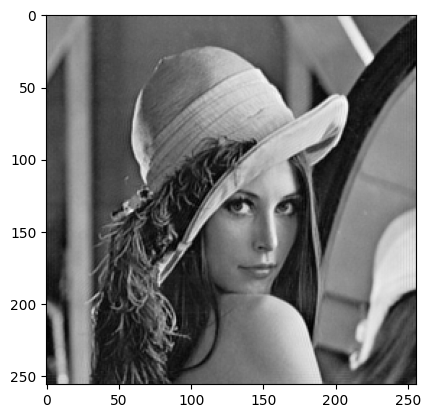

In [10]:
# Ordinary gradient descent with tikhonov regularization
x2 = np.random.rand(256,256)
b2 = image_convolved.flatten()
alpha = 0.0001
eps = 0.1
beta = 50
iteration = 1000

for i in range(iteration):
    conv, kernel = convolve(x2, sigma)
    grad = deconvolve(conv - image_convolved, kernel) + beta*x2
    new_x = x2 - alpha*grad
    stopIdx=i
    residual = new_x-x2
    if np.linalg.norm(residual) < eps:
        break
    x2 = new_x

    
print('iteration number: ',stopIdx+1)
print('reconstruction error after 1000 iteration: ',np.linalg.norm(image-x2))
plt.imshow(np.abs(x2),cmap='gray')

iteration number:  1000
reconstruction error after 1000 iteration:  30298.045408489623


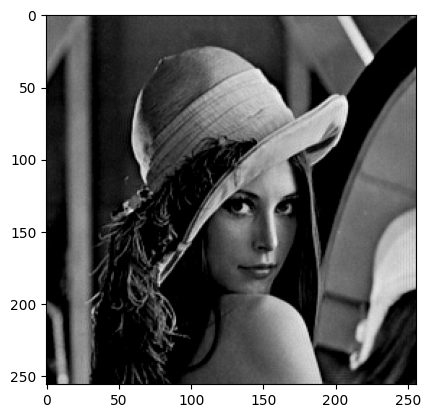

In [158]:
# ISTA
x1 = np.random.rand(256,256)
b2 = image_convolved.flatten()
alpha = 0.0001
eps = 0.1
beta = 50
stopIdx = 0

for i in range(iteration):
    conv, kernel = convolve(x2, sigma)
    grad = deconvolve(conv - image_convolved, kernel)
    x_new = GradientDescent.soft_thresh(x1 - alpha*grad, beta*alpha)
    if np.linalg.norm(x_new-x1) < eps:
        break
    stopIdx = i
    x1 = x_new

print('iteration number: ',stopIdx+1)
print('reconstruction error after 1000 iteration: ',np.linalg.norm(image-x1))
plt.imshow(np.abs(x1),cmap='gray')

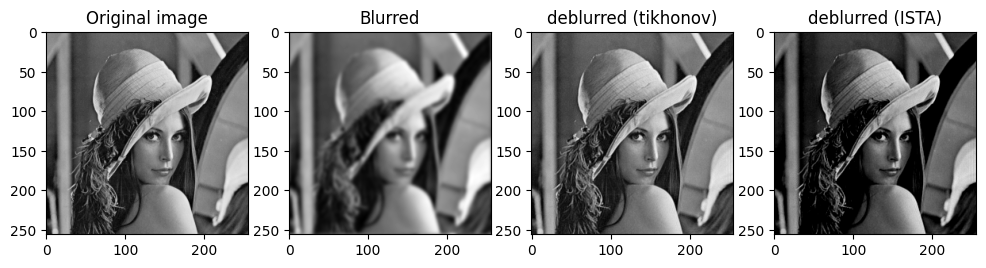

In [162]:
plt.figure(figsize=(12,12))
plt.subplot(1,4,1, title="Original image");plt.imshow(image,cmap='gray')
plt.subplot(1,4,2, title="Blurred");plt.imshow(image_convolved,cmap='gray')
plt.subplot(1,4,3, title="deblurred (tikhonov)");plt.imshow(np.abs(x2),cmap='gray')
plt.subplot(1,4,4, title="deblurred (ISTA)");plt.imshow(np.abs(x1),cmap='gray')
plt.show()